In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpStatus, LpVariable, lpSum

%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [94]:
data_raw = pd.read_csv('./data/employee_attrition_lyon_probs.csv')

## Severance package

In [95]:
data_raw['eligible_for_1/4_monthly_income'] = data_raw['YearsAtCompany'].where(data_raw['YearsAtCompany'] < 10, 10)
data_raw['eligible_for_1/3_monthly_income'] = data_raw['YearsAtCompany'] - data_raw['eligible_for_1/4_monthly_income']

# We need to use the monthly income instead of monthly rate because according to Maurice's email, the RCC
# needs to be based on the monthly salary, which is defined as 1/12 of the total amount OBTAINED over the
# past year --> Needs to be the actual income.
data_raw['severance_package'] =\
    data_raw['MonthlyIncome'] / 4 * data_raw['eligible_for_1/4_monthly_income'] +\
    data_raw['MonthlyIncome'] / 3 * data_raw['eligible_for_1/3_monthly_income'] +\
    data_raw['MonthlyIncome'] * 2

## Divide employees into groups

In [96]:
data = data_raw.copy()

In [97]:
# By monthly income
category_name = 'MonthlyIncome'
n_buckets = 20
data[f'{category_name}_category'] = pd.qcut(data[category_name], n_buckets)
data[f'{category_name}_category_code'] = data[f'{category_name}_category'].cat.codes
data.groupby(f'{category_name}_category_code').size()


MonthlyIncome_category_code
0     24
1     21
2     22
3     22
4     22
5     22
6     22
7     22
8     22
9     22
10    22
11    22
12    22
13    22
14    22
15    22
16    22
17    22
18    22
19    22
dtype: int64

In [98]:
category_cols = [col for col in data.columns if '_category_code' in col]
category_cols

['MonthlyIncome_category_code']

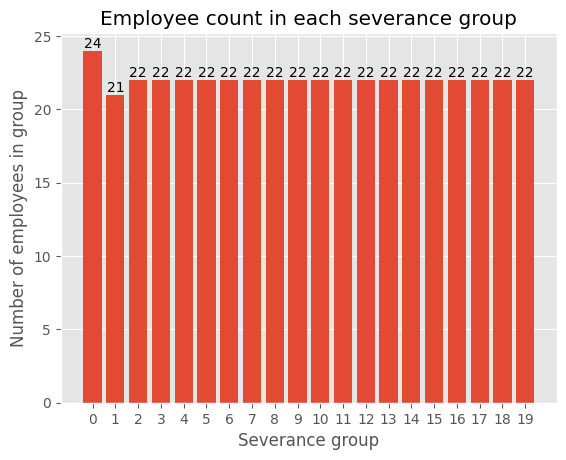

In [99]:
# Final grouping
# Make sure there's no NA
data['group_combined'] = data[category_cols].astype(str).agg('_'.join, axis=1)
assert not data.query(f'{category_name}_category_code < 0').shape[0]

data['severance_group'] = data['group_combined'].astype('category').cat.codes

severance_group_size = data.groupby('severance_group').size()

ax = plt.bar(severance_group_size.index, severance_group_size)
plt.xticks(severance_group_size.index)
plt.xlabel('Severance group')
plt.ylabel('Number of employees in group')
plt.title('Employee count in each severance group')
plt.bar_label(ax)

# Make sure there's enough employee in each category
min_employees = 5
assert (severance_group_size > min_employees).all()

## Calculate metrics for constraints

In [100]:
# region Constraint 1: Min number to offer RCC: 40.
# This is based on the probability so no need to do anything here
# endregion

# region Constraint 2: Yearly saving from salary is > 3million
# we calculate the yearly rate from monthly rate. We can't use monthly income because
# that's what the employee receives, but we are actually interested in what the company
# has to pay out
data['YearlyRate'] = data['MonthlyRate'] * 12 * data['prob_take_rcc']
# endregion

# region Constraint 3: Leaving ppl are spread evenly across job roles.
data['JobRole'] = 'role_' + data['JobRole']
role_list = data['JobRole'].unique().tolist()
role_counts = data.groupby('JobRole').size()

# Transform to wide format
data = pd.concat(
    [
        data.drop(['JobRole'], axis=1),
        data[['JobRole', 'prob_take_rcc']].pivot(columns='JobRole', values='prob_take_rcc').fillna(0),
    ],
    axis=1,
)
# endregion

# region Constraint 4: >= 80% of the employees have to stay in each department
data['Department'] = 'dept_' + data['Department']
dept_list = data['Department'].unique().tolist()
dept_counts = data.groupby('Department').size()

# Transform to wide format
data = pd.concat(
    [
        data.drop(['Department'], axis=1),
        data[['Department', 'prob_take_rcc']].pivot(columns='Department', values='prob_take_rcc').fillna(0),
    ],
    axis=1,
)
# endregion

# endregion

# region Compute the statistics for each employee category
data['employee_count'] = 1
severance_group_stats = data.groupby('severance_group', as_index=False).agg({
    'prob_take_rcc': 'sum',  # constraint 1
    'YearlyRate': 'sum',  # constraint 2
    **{role: 'sum' for role in role_list},  # constraint 3
    **{dept: 'sum' for dept in dept_list},  # constraint 4
    'severance_package': 'sum',  # objective
    'employee_count': 'sum',  # total number of employees in each group
})

severance_group_stats.to_csv('./output/severance_groups.csv', index=False)
# endregion

## Optimisation

In [101]:
def analyse_rcc_offer_rate(data, attribute_name):
    rcc_offer_by_attribute = (
        data
        .groupby(['rcc_offer', attribute_name], as_index=False).size()
        .pivot(index=attribute_name, columns='rcc_offer', values='size')
    )
    rcc_offer_by_attribute.columns = ['rcc_offered' if x == 1 else 'no_rcc_offered' for x in rcc_offer_by_attribute.columns]
    rcc_offer_by_attribute.reset_index()
    rcc_offer_by_attribute = rcc_offer_by_attribute.eval('pct_rcc_offered = rcc_offered / (rcc_offered + no_rcc_offered) * 100')

    print('\n')
    print(f'RCC offer by {attribute_name}')
    print(rcc_offer_by_attribute)

    return rcc_offer_by_attribute

### Case 1: Only constraint 1 and 2

In [102]:
# region Optimise
# region Setup
groups = severance_group_stats.copy()
model = LpProblem(name='test', sense=LpMinimize)

group_chosen = [LpVariable(name=f'severance_group{i}', cat='Binary') for i in groups['severance_group']]

severance_pays = groups['severance_package'].tolist()
total_employees_before = groups['employee_count'].sum()
# endregion

# region objective
objective = lpSum(
    [group * severance_package]
    for group, severance_package
    in zip(group_chosen, groups['severance_package'])
)

model += objective
# endregion

# region Constraint 1: Min number to offer RCC: 40.
employees_to_leave = lpSum([
    group * employee_count
    for group, employee_count
    in zip(group_chosen, groups['prob_take_rcc'])
])

employee_constraint = employees_to_leave >= 40

model += (employee_constraint, 'employee_to_offer_rcc')
# endregion

# region Constraint 2: Yearly saving from salary is >3 million
salary_constraint = lpSum([
    group * group_yearly_salary
    for group, group_yearly_salary
    in zip(group_chosen, groups['YearlyRate'])
]) >= 3_000_000

model += (salary_constraint, 'yearly_saving')
# endregion


In [103]:
# show model
# print(model)

# Solve
status = model.solve()

# Get status
print('Solver status:', LpStatus[model.status])

Solver status: Optimal


In [104]:
# region gather optimisation results
severance_group_results = []
for var in model.variables():
    severance_group_results.append({
        'severance_group': int(var.name.replace('severance_group', '')),
        'rcc_offer': var.value()
    })
severance_group_results_df = pd.DataFrame(severance_group_results)

groups_results = pd.merge(
    groups,
    severance_group_results_df,
    on='severance_group'
)

rcc_offer_groups = groups_results.query('rcc_offer == 1')

data.merge(
    severance_group_results_df,
    on='severance_group'
).to_csv('./output/severance_offer/incomplete_case.csv', index=False)

# endregion

groups_results


,severance_group,prob_take_rcc,YearlyRate,role_Sales Executive,role_Manufacturing Director,role_Human Resources,role_Research Scientist,role_Laboratory Technician,role_Sales Representative,role_Healthcare Representative,role_Manager,role_Research Director,dept_Sales,dept_Research & Development,dept_Human Resources,severance_package,employee_count,rcc_offer
0,0,5.675262,9.930374e+05,0.000000,0.000000,1.254420,1.614097,2.740774,0.065972,0.000000,0.000000,0.000000,0.065972,4.354871,1.254420,1.245850e+05,24,1.0
1,1,4.029971,6.496417e+05,0.000000,0.000000,0.000000,1.350682,1.490898,1.188392,0.000000,0.000000,0.000000,1.188392,2.841579,0.000000,1.439101e+05,21,1.0
2,2,3.223162,6.129052e+05,2.425987,0.139842,0.000000,0.162325,0.363875,0.000000,0.131133,0.000000,0.000000,2.425987,0.797175,0.000000,4.612430e+05,22,0.0
3,3,4.839925,1.097653e+06,2.507472,1.289114,0.108838,0.052081,0.741989,0.000000,0.140432,0.000000,0.000000,2.507472,2.223615,0.108838,5.070306e+05,22,1.0
4,4,1.492655,2.369638e+05,1.035356,0.110260,0.101656,0.000000,0.042508,0.000000,0.202875,0.000000,0.000000,1.035356,0.355643,0.101656,5.325201e+05,22,0.0
5,5,1.277356,2.271702e+05,0.835002,0.252047,0.000000,0.000000,0.110412,0.000000,0.079896,0.000000,0.000000,0.835002,0.442354,0.000000,5.055422e+05,22,0.0
6,6,3.297585,5.349687e+05,1.918538,0.995986,0.224158,0.000000,0.085660,0.000000,0.073243,0.000000,0.000000,1.918538,1.154889,0.224158,7.136486e+05,22,0.0
7,7,2.968001,5.052500e+05,2.551810,0.274139,0.000000,0.000000,0.000000,0.000000,0.142053,0.000000,0.000000,2.551810,0.416191,0.000000,7.953483e+05,22,0.0
8,8,2.926451,4.274920e+05,1.955369,0.398863,0.038805,0.004300,0.000000,0.000000,0.529115,0.000000,0.000000,1.955369,0.932277,0.038805,1.086016e+06,22,0.0
9,9,3.270749,8.033660e+05,2.002823,0.027739,0.000000,0.000000,0.000000,0.000000,0.477057,0.573472,0.189658,2.002823,1.267926,0.000000,1.390674e+06,22,0.0


In [105]:
# region analyse optimisation results
# Objective: severance pay
severance_pay = rcc_offer_groups['severance_package'].sum() / 1000000
print(f'Severance pay: €{severance_pay:.2f} million')

# Constraint 1: Number of people to offer RCC
leavings = rcc_offer_groups['prob_take_rcc'].sum()
print(f'Number of employees leaving: {leavings:.2f}')

assert leavings >= 40

# Constraint 2: Yearly saving
yearly_saving = rcc_offer_groups['YearlyRate'].sum() / 1000000
print(f'Yearly saving: €{yearly_saving:.2f} million')

assert yearly_saving > 3

# analyse protected attributes
data_protected = pd.merge(
    data,
    severance_group_results_df,
    on='severance_group'
)

# Gender
_ = analyse_rcc_offer_rate(data_protected, 'Gender')

# Age
data_protected['age_group'] = pd.qcut(data_protected['Age'], 5)
_ = analyse_rcc_offer_rate(data_protected, 'age_group')

# Marital Status
_ = analyse_rcc_offer_rate(data_protected, 'MaritalStatus')


Severance pay: €2.30 million
Number of employees leaving: 41.15
Yearly saving: €7.30 million


RCC offer by Gender
        no_rcc_offered  rcc_offered  pct_rcc_offered
Gender                                              
Female             100           76        43.181818
Male               142          123        46.415094


RCC offer by age_group
                no_rcc_offered  rcc_offered  pct_rcc_offered
age_group                                                   
(17.999, 31.0]              37           58        61.052632
(31.0, 34.0]                33           31        48.437500
(34.0, 39.0]                46           30        39.473684
(39.0, 46.0]                53           30        36.144578
(46.0, 60.0]                53           15        22.058824


RCC offer by MaritalStatus
               no_rcc_offered  rcc_offered  pct_rcc_offered
MaritalStatus                                              
Divorced                   55           40        42.105263
Married     

### Case 2: Constraint 3 and 4 added

In [106]:
# region Optimise
# region Setup
groups = severance_group_stats.copy()
model = LpProblem(name='test', sense=LpMinimize)

group_chosen = [LpVariable(name=f'severance_group{i}', cat='Binary') for i in groups['severance_group']]

severance_pays = groups['severance_package'].tolist()
total_employees_before = groups['employee_count'].sum()
# endregion

# region objective
objective = lpSum(
    [group * severance_package]
    for group, severance_package
    in zip(group_chosen, groups['severance_package'])
)

model += objective
# endregion

# region Constraint 1: Min number to offer RCC: 40.
employees_to_leave = lpSum([
    group * employee_count
    for group, employee_count
    in zip(group_chosen, groups['prob_take_rcc'])
])

employee_constraint = employees_to_leave >= 40

model += (employee_constraint, 'employee_to_offer_rcc')
# endregion

# region Constraint 2: Yearly saving from salary is >3 million
salary_constraint = lpSum([
    group * group_yearly_salary
    for group, group_yearly_salary
    in zip(group_chosen, groups['YearlyRate'])
]) >= 3_000_000

model += (salary_constraint, 'yearly_saving')
# endregion

# region Constraint 3: Leaving ppl are spread evenly across job roles.
tolerance = 0.1
roles = role_counts.index

total_employees_after = total_employees_before - employees_to_leave

for role in roles:
    # Number of employees in the current role before the RCC
    count_employee_in_role_before = role_counts[role]

    # Pct of employees from the current role before the RCC
    pct_in_role_before = count_employee_in_role_before / total_employees_before

    # Number of employees remaining in the current role after the RCC
    count_employee_in_role_after = count_employee_in_role_before - lpSum([
        group * count_employees_with_role_in_group
        for group, count_employees_with_role_in_group
        in zip(group_chosen, groups[role])
    ])

    # Target number of employees remaining in the current role after the RCC
    target_count_employee_in_role_after = pct_in_role_before * total_employees_after

    # Add constraint
    model += (
        count_employee_in_role_after >= (target_count_employee_in_role_after * (1 - tolerance)),
        f'min_remaining_{role}'
    )

    model += (
        count_employee_in_role_after <= (target_count_employee_in_role_after * (1 + tolerance)),
        f'max_remaining_{role}'
    )
# endregion

# region Constraint 4: >= 80% of the employees have to stay in each department
depts = dept_counts.index

for dept in depts:
    # Number of employees in the department before
    count_employee_in_department_before = dept_counts[dept]

    total_employee_in_dept_after = count_employee_in_department_before - lpSum([
        group * count_employees_in_department_in_group
        for group, count_employees_in_department_in_group
        in zip(group_chosen, groups[dept])
    ])

    model += (
        total_employee_in_dept_after >= (count_employee_in_department_before * 0.8),
        f'remaining_{dept}'
    )
# endregion

In [107]:
# show model
# print(model)

# Solve
status = model.solve()

# Get status
print('Solver status:', LpStatus[model.status])

Solver status: Optimal


In [108]:
# region gather optimisation results
severance_group_results = []
for var in model.variables():
    severance_group_results.append({
        'severance_group': int(var.name.replace('severance_group', '')),
        'rcc_offer': var.value()
    })
severance_group_results_df = pd.DataFrame(severance_group_results)

groups_results = pd.merge(
    groups,
    severance_group_results_df,
    on='severance_group'
)

rcc_offer_groups = groups_results.query('rcc_offer == 1')

data.merge(
    severance_group_results_df,
    on='severance_group'
).to_csv('./output/severance_offer/complete_case_income.csv', index=False)

# endregion

groups_results


,severance_group,prob_take_rcc,YearlyRate,role_Sales Executive,role_Manufacturing Director,role_Human Resources,role_Research Scientist,role_Laboratory Technician,role_Sales Representative,role_Healthcare Representative,role_Manager,role_Research Director,dept_Sales,dept_Research & Development,dept_Human Resources,severance_package,employee_count,rcc_offer
0,0,5.675262,9.930374e+05,0.000000,0.000000,1.254420,1.614097,2.740774,0.065972,0.000000,0.000000,0.000000,0.065972,4.354871,1.254420,1.245850e+05,24,1.0
1,1,4.029971,6.496417e+05,0.000000,0.000000,0.000000,1.350682,1.490898,1.188392,0.000000,0.000000,0.000000,1.188392,2.841579,0.000000,1.439101e+05,21,1.0
2,2,3.223162,6.129052e+05,2.425987,0.139842,0.000000,0.162325,0.363875,0.000000,0.131133,0.000000,0.000000,2.425987,0.797175,0.000000,4.612430e+05,22,1.0
3,3,4.839925,1.097653e+06,2.507472,1.289114,0.108838,0.052081,0.741989,0.000000,0.140432,0.000000,0.000000,2.507472,2.223615,0.108838,5.070306e+05,22,1.0
4,4,1.492655,2.369638e+05,1.035356,0.110260,0.101656,0.000000,0.042508,0.000000,0.202875,0.000000,0.000000,1.035356,0.355643,0.101656,5.325201e+05,22,0.0
5,5,1.277356,2.271702e+05,0.835002,0.252047,0.000000,0.000000,0.110412,0.000000,0.079896,0.000000,0.000000,0.835002,0.442354,0.000000,5.055422e+05,22,0.0
6,6,3.297585,5.349687e+05,1.918538,0.995986,0.224158,0.000000,0.085660,0.000000,0.073243,0.000000,0.000000,1.918538,1.154889,0.224158,7.136486e+05,22,0.0
7,7,2.968001,5.052500e+05,2.551810,0.274139,0.000000,0.000000,0.000000,0.000000,0.142053,0.000000,0.000000,2.551810,0.416191,0.000000,7.953483e+05,22,0.0
8,8,2.926451,4.274920e+05,1.955369,0.398863,0.038805,0.004300,0.000000,0.000000,0.529115,0.000000,0.000000,1.955369,0.932277,0.038805,1.086016e+06,22,0.0
9,9,3.270749,8.033660e+05,2.002823,0.027739,0.000000,0.000000,0.000000,0.000000,0.477057,0.573472,0.189658,2.002823,1.267926,0.000000,1.390674e+06,22,0.0


In [109]:
# region analyse optimisation results
# Objective: severance pay
severance_pay = rcc_offer_groups['severance_package'].sum() / 1000000
print(f'Severance pay: €{severance_pay:.2f} million')

# Constraint 1: Number of people to offer RCC
leavings = rcc_offer_groups['prob_take_rcc'].sum()
print(f'Number of employees leaving: {leavings:.2f}')

assert leavings >= 40

# Constraint 2: Yearly saving
yearly_saving = rcc_offer_groups['YearlyRate'].sum() / 1000000
print(f'Yearly saving: €{yearly_saving:.2f} million')

assert yearly_saving > 3

# Constraint 3: Leaving ppl are spread evenly across job roles
total_headcount_after = total_employees_before - leavings

role_changes = pd.concat(
    [
        role_counts / total_employees_before * 100,  # before
        (role_counts - rcc_offer_groups[roles].sum()) / total_headcount_after * 100,  # after
    ],
    axis=1
)
role_changes.columns = ['pct_before', 'pct_after']
role_changes = role_changes.eval('relative_change = (pct_after - pct_before) / pct_before * 100').reset_index()
role_changes['JobRole'] = role_changes['JobRole'].str.replace('role_', '')

print('\n')
print('----------- Role changes')
print(role_changes)

assert (role_changes['relative_change'].abs() <= tolerance * 100).all()

# Constraint 4: >= 80% of the employees have to stay in each department
dept_changes = pd.concat(
    [
        dept_counts,  # before
        dept_counts - rcc_offer_groups[depts].sum(),  # after
    ],
    axis=1,
)
dept_changes.columns = ['employee_count_before', 'employee_count_after']
dept_changes = dept_changes.eval('pct_remaining = employee_count_after / employee_count_before * 100').reset_index()
dept_changes['Department'] = dept_changes['Department'].str.replace('dept_', '')

print('\n')
print('----------- Department changes')
print(dept_changes)

assert (dept_changes['pct_remaining'].abs() >= 0.8).all()

# endregion

# analyse protected attributes
data_protected = pd.merge(
    data,
    severance_group_results_df,
    on='severance_group'
)

# Gender
_ = analyse_rcc_offer_rate(data_protected, 'Gender')

# Age
data_protected['age_group'] = pd.qcut(data_protected['Age'], 5)
_ = analyse_rcc_offer_rate(data_protected, 'age_group')

# Marital Status
_ = analyse_rcc_offer_rate(data_protected, 'MaritalStatus')


Severance pay: €2.61 million
Number of employees leaving: 40.05
Yearly saving: €7.40 million


----------- Role changes
                     JobRole  pct_before  pct_after  relative_change
0  Healthcare Representative    9.523810  10.302843         8.179848
1            Human Resources    4.081633   3.941122        -3.442502
2      Laboratory Technician   18.140590  16.379414        -9.708481
3                    Manager    6.575964   7.232752         9.987705
4     Manufacturing Director   11.337868  11.920956         5.142832
5          Research Director    4.081633   4.489294         9.987705
6         Research Scientist   17.687075  16.934432        -4.255329
7            Sales Executive   24.716553  25.314057         2.417424
8       Sales Representative    3.854875   3.485131        -9.591609


----------- Department changes
               Department  employee_count_before  employee_count_after  pct_remaining
0         Human Resources                     21             18.802084 

## Different categorisation strategy

What if we divide employees based on a combination of categories?

### Case 3: MonthlyIncome x JobSatisfaction

#### Optimise

In [110]:
data = data_raw.copy()

In [111]:
# By monthly income
category_name = 'MonthlyIncome'
n_buckets = 5
data[f'{category_name}_category'] = pd.qcut(data[category_name], n_buckets)
data[f'{category_name}_category_code'] = data[f'{category_name}_category'].cat.codes
data.groupby(f'{category_name}_category_code').size()


MonthlyIncome_category_code
0    89
1    88
2    88
3    88
4    88
dtype: int64

In [112]:
# By satisfaction
category_name = 'JobSatisfaction'
n_buckets = 3

data[f'{category_name}_category_code'] = data[category_name]
data.groupby(f'{category_name}_category_code').size()


JobSatisfaction_category_code
1     91
2     65
3    141
4    144
dtype: int64

In [113]:
category_cols = [col for col in data.columns if '_category_code' in col]
category_cols

['MonthlyIncome_category_code', 'JobSatisfaction_category_code']

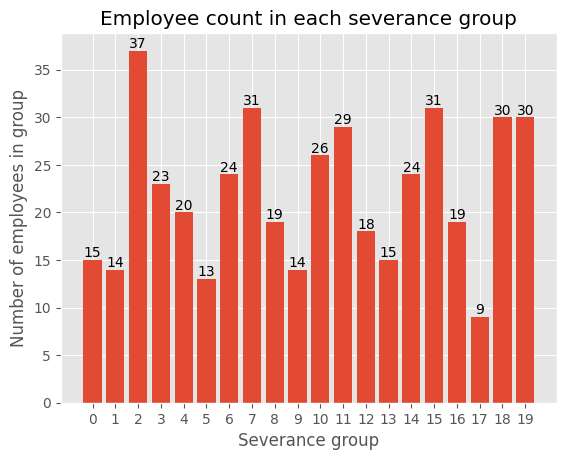

In [114]:
# Final grouping
# Make sure there's no NA
data['group_combined'] = data[category_cols].astype(str).agg('_'.join, axis=1)
assert not data.query(f'{category_name}_category_code < 0').shape[0]

data['severance_group'] = data['group_combined'].astype('category').cat.codes

severance_group_size = data.groupby('severance_group').size()

ax = plt.bar(severance_group_size.index, severance_group_size)
plt.xticks(severance_group_size.index)
plt.xlabel('Severance group')
plt.ylabel('Number of employees in group')
plt.title('Employee count in each severance group')
plt.bar_label(ax)

# Make sure there's enough employee in each category
min_employees = 5
assert (severance_group_size > min_employees).all()

In [115]:
# region Constraint 1: Min number to offer RCC: 40.
# This is based on the probability so no need to do anything here
# endregion

# region Constraint 2: Yearly saving from salary is > 3million
# we calculate the yearly rate from monthly rate. We can't use monthly income because
# that's what the employee receives, but we are actually interested in what the company
# has to pay out
data['YearlyRate'] = data['MonthlyRate'] * 12 * data['prob_take_rcc']
# endregion

# region Constraint 3: Leaving ppl are spread evenly across job roles.
data['JobRole'] = 'role_' + data['JobRole']
role_list = data['JobRole'].unique().tolist()
role_counts = data.groupby('JobRole').size()

# Transform to wide format
data = pd.concat(
    [
        data.drop(['JobRole'], axis=1),
        data[['JobRole', 'prob_take_rcc']].pivot(columns='JobRole', values='prob_take_rcc').fillna(0),
    ],
    axis=1,
)
# endregion

# region Constraint 4: >= 80% of the employees have to stay in each department
data['Department'] = 'dept_' + data['Department']
dept_list = data['Department'].unique().tolist()
dept_counts = data.groupby('Department').size()

# Transform to wide format
data = pd.concat(
    [
        data.drop(['Department'], axis=1),
        data[['Department', 'prob_take_rcc']].pivot(columns='Department', values='prob_take_rcc').fillna(0),
    ],
    axis=1,
)
# endregion

# endregion

# region Compute the statistics for each employee category
data['employee_count'] = 1
severance_group_stats = data.groupby('severance_group', as_index=False).agg({
    'prob_take_rcc': 'sum',  # constraint 1
    'YearlyRate': 'sum',  # constraint 2
    **{role: 'sum' for role in role_list},  # constraint 3
    **{dept: 'sum' for dept in dept_list},  # constraint 4
    'severance_package': 'sum',  # objective
    'employee_count': 'sum',  # total number of employees in each group
})

severance_group_stats.to_csv('./output/severance_groups.csv', index=False)
# endregion

In [116]:
# region Optimise
# region Setup
groups = severance_group_stats.copy()
model = LpProblem(name='test', sense=LpMinimize)

group_chosen = [LpVariable(name=f'severance_group{i}', cat='Binary') for i in groups['severance_group']]

severance_pays = groups['severance_package'].tolist()
total_employees_before = groups['employee_count'].sum()
# endregion

# region objective
objective = lpSum(
    [group * severance_package]
    for group, severance_package
    in zip(group_chosen, groups['severance_package'])
)

model += objective
# endregion

# region Constraint 1: Min number to offer RCC: 40.
employees_to_leave = lpSum([
    group * employee_count
    for group, employee_count
    in zip(group_chosen, groups['prob_take_rcc'])
])

employee_constraint = employees_to_leave >= 40

model += (employee_constraint, 'employee_to_offer_rcc')
# endregion

# region Constraint 2: Yearly saving from salary is >3 million
salary_constraint = lpSum([
    group * group_yearly_salary
    for group, group_yearly_salary
    in zip(group_chosen, groups['YearlyRate'])
]) >= 3_000_000

model += (salary_constraint, 'yearly_saving')
# endregion

# region Constraint 3: Leaving ppl are spread evenly across job roles.
tolerance = 0.1
roles = role_counts.index

total_employees_after = total_employees_before - employees_to_leave

for role in roles:
    # Number of employees in the current role before the RCC
    count_employee_in_role_before = role_counts[role]

    # Pct of employees from the current role before the RCC
    pct_in_role_before = count_employee_in_role_before / total_employees_before

    # Number of employees remaining in the current role after the RCC
    count_employee_in_role_after = count_employee_in_role_before - lpSum([
        group * count_employees_with_role_in_group
        for group, count_employees_with_role_in_group
        in zip(group_chosen, groups[role])
    ])

    # Target number of employees remaining in the current role after the RCC
    target_count_employee_in_role_after = pct_in_role_before * total_employees_after

    # Add constraint
    model += (
        count_employee_in_role_after >= (target_count_employee_in_role_after * (1 - tolerance)),
        f'min_remaining_{role}'
    )

    model += (
        count_employee_in_role_after <= (target_count_employee_in_role_after * (1 + tolerance)),
        f'max_remaining_{role}'
    )
# endregion

# region Constraint 4: >= 80% of the employees have to stay in each department
depts = dept_counts.index

for dept in depts:
    # Number of employees in the department before
    count_employee_in_department_before = dept_counts[dept]

    total_employee_in_dept_after = count_employee_in_department_before - lpSum([
        group * count_employees_in_department_in_group
        for group, count_employees_in_department_in_group
        in zip(group_chosen, groups[dept])
    ])

    model += (
        total_employee_in_dept_after >= (count_employee_in_department_before * 0.8),
        f'remaining_{dept}'
    )
# endregion

In [117]:
# show model
# print(model)

# Solve
status = model.solve()

# Get status
print('Solver status:', LpStatus[model.status])

Solver status: Optimal


In [118]:
# region gather optimisation results
severance_group_results = []
for var in model.variables():
    severance_group_results.append({
        'severance_group': int(var.name.replace('severance_group', '')),
        'rcc_offer': var.value()
    })
severance_group_results_df = pd.DataFrame(severance_group_results)

groups_results = pd.merge(
    groups,
    severance_group_results_df,
    on='severance_group'
)

rcc_offer_groups = groups_results.query('rcc_offer == 1')

data.merge(
    severance_group_results_df,
    on='severance_group'
).to_csv('./output/severance_offer/complete_case_income_jobsatisfaction.csv', index=False)

# endregion

groups_results


,severance_group,prob_take_rcc,YearlyRate,role_Sales Executive,role_Manufacturing Director,role_Human Resources,role_Research Scientist,role_Laboratory Technician,role_Sales Representative,role_Healthcare Representative,role_Manager,role_Research Director,dept_Sales,dept_Research & Development,dept_Human Resources,severance_package,employee_count,rcc_offer
0,0,4.615515,9.662366e+05,0.000000,0.000000,0.455081,1.639690,2.247093,0.273651,0.000000,0.000000,0.000000,0.273651,3.886783,0.455081,1.089513e+05,15,1.0
1,1,2.743256,3.849523e+05,0.000000,0.000000,0.491483,0.909254,0.837887,0.504632,0.000000,0.000000,0.000000,0.504632,1.747141,0.491483,9.597150e+04,14,1.0
2,2,8.491160,1.448447e+06,0.000000,0.000000,0.790738,1.215889,4.229426,2.255107,0.000000,0.000000,0.000000,2.255107,5.445315,0.790738,2.748366e+05,37,1.0
3,3,3.900481,6.988543e+05,0.000000,0.000000,0.589520,0.540576,2.145737,0.624648,0.000000,0.000000,0.000000,0.624648,2.686312,0.589520,1.481509e+05,23,0.0
4,4,3.721207,5.208430e+05,0.723822,0.461172,0.148193,1.538763,0.849257,0.000000,0.000000,0.000000,0.000000,0.723822,2.849192,0.148193,2.734589e+05,20,1.0
5,5,3.450887,6.565448e+05,0.000000,0.000000,0.006019,2.229705,1.213409,0.000000,0.001754,0.000000,0.000000,0.000000,3.444868,0.006019,1.781195e+05,13,0.0
6,6,4.223968,6.905185e+05,0.200822,0.005965,0.000000,0.300684,3.452614,0.000000,0.263882,0.000000,0.000000,0.200822,4.023146,0.000000,3.414469e+05,24,1.0
7,7,5.511279,1.139958e+06,1.338375,0.000000,0.090926,1.752378,1.654972,0.668826,0.005802,0.000000,0.000000,2.007201,3.413152,0.090926,4.202679e+05,31,0.0
8,8,3.313745,6.627723e+05,2.040695,0.470561,0.000000,0.239326,0.557253,0.000000,0.005910,0.000000,0.000000,2.040695,1.273050,0.000000,3.711333e+05,19,1.0
9,9,2.118609,3.321170e+05,1.163761,0.508717,0.000000,0.025129,0.145707,0.000000,0.275295,0.000000,0.000000,1.163761,0.954848,0.000000,2.562120e+05,14,1.0


#### Results

In [119]:
# region analyse optimisation results
# Objective: severance pay
severance_pay = rcc_offer_groups['severance_package'].sum() / 1000000
print(f'Severance pay: €{severance_pay:.2f} million')

# Constraint 1: Number of people to offer RCC
leavings = rcc_offer_groups['prob_take_rcc'].sum()
print(f'Number of employees leaving: {leavings:.2f}')

assert leavings >= 40

# Constraint 2: Yearly saving
yearly_saving = rcc_offer_groups['YearlyRate'].sum() / 1000000
print(f'Yearly saving: €{yearly_saving:.2f} million')

assert yearly_saving > 3

# Constraint 3: Leaving ppl are spread evenly across job roles
total_headcount_after = total_employees_before - leavings

role_changes = pd.concat(
    [
        role_counts / total_employees_before * 100,  # before
        (role_counts - rcc_offer_groups[roles].sum()) / total_headcount_after * 100,  # after
    ],
    axis=1
)
role_changes.columns = ['pct_before', 'pct_after']
role_changes = role_changes.eval('relative_change = (pct_after - pct_before) / pct_before * 100').reset_index()
role_changes['JobRole'] = role_changes['JobRole'].str.replace('role_', '')

print('\n')
print('----------- Role changes')
print(role_changes)

assert (role_changes['relative_change'].abs() <= tolerance * 100).all()

# Constraint 4: >= 80% of the employees have to stay in each department
dept_changes = pd.concat(
    [
        dept_counts,  # before
        dept_counts - rcc_offer_groups[depts].sum(),  # after
    ],
    axis=1,
)
dept_changes.columns = ['employee_count_before', 'employee_count_after']
dept_changes = dept_changes.eval('pct_remaining = employee_count_after / employee_count_before * 100').reset_index()
dept_changes['Department'] = dept_changes['Department'].str.replace('dept_', '')

print('\n')
print('----------- Department changes')
print(dept_changes)

assert (dept_changes['pct_remaining'].abs() >= 0.8).all()

# endregion

# analyse protected attributes
data_protected = pd.merge(
    data,
    severance_group_results_df,
    on='severance_group'
)

# Gender
_ = analyse_rcc_offer_rate(data_protected, 'Gender')

# Age
data_protected['age_group'] = pd.qcut(data_protected['Age'], 5)
_ = analyse_rcc_offer_rate(data_protected, 'age_group')

# Marital Status
_ = analyse_rcc_offer_rate(data_protected, 'MaritalStatus')


Severance pay: €3.77 million
Number of employees leaving: 40.04
Yearly saving: €6.97 million


----------- Role changes
                     JobRole  pct_before  pct_after  relative_change
0  Healthcare Representative    9.523810  10.220522         7.315482
1            Human Resources    4.081633   3.909776        -4.210498
2      Laboratory Technician   18.140590  16.653789        -8.195988
3                    Manager    6.575964   7.232670         9.986464
4     Manufacturing Director   11.337868  11.683808         3.051187
5          Research Director    4.081633   4.489243         9.986464
6         Research Scientist   17.687075  17.856125         0.955782
7            Sales Executive   24.716553  24.470761        -0.994445
8       Sales Representative    3.854875   3.483306        -9.638938


----------- Department changes
               Department  employee_count_before  employee_count_after  pct_remaining
0         Human Resources                     21             18.676575 

### Case 4: Monthly Income X Environment Satisfaction

#### Optimise

In [120]:
data = data_raw.copy()

In [121]:
# By monthly income
category_name = 'MonthlyIncome'
n_buckets = 5
data[f'{category_name}_category'] = pd.qcut(data[category_name], n_buckets)
data[f'{category_name}_category_code'] = data[f'{category_name}_category'].cat.codes
data.groupby(f'{category_name}_category_code').size()


MonthlyIncome_category_code
0    89
1    88
2    88
3    88
4    88
dtype: int64

In [122]:
# By satisfaction
category_name = 'EnvironmentSatisfaction'
n_buckets = 3

data[f'{category_name}_category_code'] = data[category_name]
data.groupby(f'{category_name}_category_code').size()


EnvironmentSatisfaction_category_code
1     77
2     75
3    143
4    146
dtype: int64

In [123]:
category_cols = [col for col in data.columns if '_category_code' in col]
category_cols

['MonthlyIncome_category_code', 'EnvironmentSatisfaction_category_code']

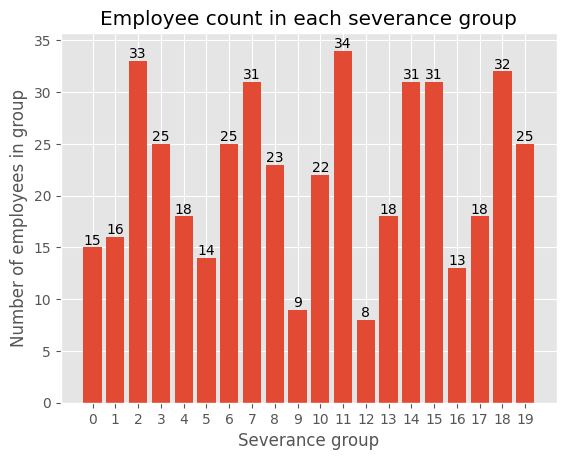

In [124]:
# Final grouping
# Make sure there's no NA
data['group_combined'] = data[category_cols].astype(str).agg('_'.join, axis=1)
assert not data.query(f'{category_name}_category_code < 0').shape[0]

data['severance_group'] = data['group_combined'].astype('category').cat.codes

severance_group_size = data.groupby('severance_group').size()

ax = plt.bar(severance_group_size.index, severance_group_size)
plt.xticks(severance_group_size.index)
plt.xlabel('Severance group')
plt.ylabel('Number of employees in group')
plt.title('Employee count in each severance group')
plt.bar_label(ax)

# Make sure there's enough employee in each category
min_employees = 5
assert (severance_group_size > min_employees).all()

In [125]:
# region Constraint 1: Min number to offer RCC: 40.
# This is based on the probability so no need to do anything here
# endregion

# region Constraint 2: Yearly saving from salary is > 3million
# we calculate the yearly rate from monthly rate. We can't use monthly income because
# that's what the employee receives, but we are actually interested in what the company
# has to pay out
data['YearlyRate'] = data['MonthlyRate'] * 12 * data['prob_take_rcc']
# endregion

# region Constraint 3: Leaving ppl are spread evenly across job roles.
data['JobRole'] = 'role_' + data['JobRole']
role_list = data['JobRole'].unique().tolist()
role_counts = data.groupby('JobRole').size()

# Transform to wide format
data = pd.concat(
    [
        data.drop(['JobRole'], axis=1),
        data[['JobRole', 'prob_take_rcc']].pivot(columns='JobRole', values='prob_take_rcc').fillna(0),
    ],
    axis=1,
)
# endregion

# region Constraint 4: >= 80% of the employees have to stay in each department
data['Department'] = 'dept_' + data['Department']
dept_list = data['Department'].unique().tolist()
dept_counts = data.groupby('Department').size()

# Transform to wide format
data = pd.concat(
    [
        data.drop(['Department'], axis=1),
        data[['Department', 'prob_take_rcc']].pivot(columns='Department', values='prob_take_rcc').fillna(0),
    ],
    axis=1,
)
# endregion

# endregion

# region Compute the statistics for each employee category
data['employee_count'] = 1
severance_group_stats = data.groupby('severance_group', as_index=False).agg({
    'prob_take_rcc': 'sum',  # constraint 1
    'YearlyRate': 'sum',  # constraint 2
    **{role: 'sum' for role in role_list},  # constraint 3
    **{dept: 'sum' for dept in dept_list},  # constraint 4
    'severance_package': 'sum',  # objective
    'employee_count': 'sum',  # total number of employees in each group
})

severance_group_stats.to_csv('./output/severance_groups.csv', index=False)
# endregion

In [126]:
# region Optimise
# region Setup
groups = severance_group_stats.copy()
model = LpProblem(name='test', sense=LpMinimize)

group_chosen = [LpVariable(name=f'severance_group{i}', cat='Binary') for i in groups['severance_group']]

severance_pays = groups['severance_package'].tolist()
total_employees_before = groups['employee_count'].sum()
# endregion

# region objective
objective = lpSum(
    [group * severance_package]
    for group, severance_package
    in zip(group_chosen, groups['severance_package'])
)

model += objective
# endregion

# region Constraint 1: Min number to offer RCC: 40.
employees_to_leave = lpSum([
    group * employee_count
    for group, employee_count
    in zip(group_chosen, groups['prob_take_rcc'])
])

employee_constraint = employees_to_leave >= 40

model += (employee_constraint, 'employee_to_offer_rcc')
# endregion

# region Constraint 2: Yearly saving from salary is >3 million
salary_constraint = lpSum([
    group * group_yearly_salary
    for group, group_yearly_salary
    in zip(group_chosen, groups['YearlyRate'])
]) >= 3_000_000

model += (salary_constraint, 'yearly_saving')
# endregion

# region Constraint 3: Leaving ppl are spread evenly across job roles.
tolerance = 0.1
roles = role_counts.index

total_employees_after = total_employees_before - employees_to_leave

for role in roles:
    # Number of employees in the current role before the RCC
    count_employee_in_role_before = role_counts[role]

    # Pct of employees from the current role before the RCC
    pct_in_role_before = count_employee_in_role_before / total_employees_before

    # Number of employees remaining in the current role after the RCC
    count_employee_in_role_after = count_employee_in_role_before - lpSum([
        group * count_employees_with_role_in_group
        for group, count_employees_with_role_in_group
        in zip(group_chosen, groups[role])
    ])

    # Target number of employees remaining in the current role after the RCC
    target_count_employee_in_role_after = pct_in_role_before * total_employees_after

    # Add constraint
    model += (
        count_employee_in_role_after >= (target_count_employee_in_role_after * (1 - tolerance)),
        f'min_remaining_{role}'
    )

    model += (
        count_employee_in_role_after <= (target_count_employee_in_role_after * (1 + tolerance)),
        f'max_remaining_{role}'
    )
# endregion

# region Constraint 4: >= 80% of the employees have to stay in each department
depts = dept_counts.index

for dept in depts:
    # Number of employees in the department before
    count_employee_in_department_before = dept_counts[dept]

    total_employee_in_dept_after = count_employee_in_department_before - lpSum([
        group * count_employees_in_department_in_group
        for group, count_employees_in_department_in_group
        in zip(group_chosen, groups[dept])
    ])

    model += (
        total_employee_in_dept_after >= (count_employee_in_department_before * 0.8),
        f'remaining_{dept}'
    )
# endregion

In [127]:
# show model
# print(model)

# Solve
status = model.solve()

# Get status
print('Solver status:', LpStatus[model.status])

Solver status: Optimal


In [128]:
# region gather optimisation results
severance_group_results = []
for var in model.variables():
    severance_group_results.append({
        'severance_group': int(var.name.replace('severance_group', '')),
        'rcc_offer': var.value()
    })
severance_group_results_df = pd.DataFrame(severance_group_results)

groups_results = pd.merge(
    groups,
    severance_group_results_df,
    on='severance_group'
)

rcc_offer_groups = groups_results.query('rcc_offer == 1')

data.merge(
    severance_group_results_df,
    on='severance_group'
).to_csv('./output/severance_offer/complete_case_income_envsatisfaction.csv', index=False)

# endregion

groups_results


,severance_group,prob_take_rcc,YearlyRate,role_Sales Executive,role_Manufacturing Director,role_Human Resources,role_Research Scientist,role_Laboratory Technician,role_Sales Representative,role_Healthcare Representative,role_Manager,role_Research Director,dept_Sales,dept_Research & Development,dept_Human Resources,severance_package,employee_count,rcc_offer
0,0,4.332848,8.843476e+05,0.000000,0.000000,0.589520,1.585929,2.157399,0.000000,0.000000,0.000000,0.000000,0.000000,3.743328,0.589520,1.032030e+05,15,1.0
1,1,3.010279,4.369411e+05,0.000000,0.000000,0.614257,0.635392,0.971445,0.789185,0.000000,0.000000,0.000000,0.789185,1.606838,0.614257,1.197196e+05,16,0.0
2,2,5.906137,1.075717e+06,0.000000,0.000000,0.815189,1.068591,2.280350,1.742007,0.000000,0.000000,0.000000,1.742007,3.348941,0.815189,2.333852e+05,33,1.0
3,3,6.501148,1.101485e+06,0.000000,0.000000,0.307856,1.015497,4.050949,1.126846,0.000000,0.000000,0.000000,1.126846,5.066445,0.307856,1.716025e+05,25,1.0
4,4,4.617441,6.704819e+05,0.008859,0.000000,0.000000,2.510361,2.098221,0.000000,0.000000,0.000000,0.000000,0.008859,4.608582,0.000000,2.507072e+05,18,1.0
5,5,1.767961,3.454607e+05,0.210412,0.007316,0.090926,0.343429,1.052433,0.000000,0.063445,0.000000,0.000000,0.210412,1.466623,0.090926,2.274096e+05,14,0.0
6,6,5.511032,1.040794e+06,1.497727,0.450825,0.006019,1.725096,1.829611,0.000000,0.001754,0.000000,0.000000,1.497727,4.007286,0.006019,3.378029e+05,25,1.0
7,7,5.010906,9.511277e+05,0.546020,0.008995,0.148193,1.242644,2.189987,0.668826,0.206240,0.000000,0.000000,1.214847,3.647867,0.148193,3.973736e+05,31,0.0
8,8,4.731920,1.095696e+06,3.230822,0.506084,0.071488,0.008189,0.778862,0.000000,0.136476,0.000000,0.000000,3.230822,1.429610,0.071488,4.531584e+05,23,1.0
9,9,0.932805,1.834174e+05,0.028541,0.514173,0.000000,0.113661,0.139387,0.000000,0.137044,0.000000,0.000000,0.028541,0.904264,0.000000,1.606662e+05,9,0.0


#### Results

In [129]:
# region analyse optimisation results
# Objective: severance pay
severance_pay = rcc_offer_groups['severance_package'].sum() / 1000000
print(f'Severance pay: €{severance_pay:.2f} million')

# Constraint 1: Number of people to offer RCC
leavings = rcc_offer_groups['prob_take_rcc'].sum()
print(f'Number of employees leaving: {leavings:.2f}')

assert leavings >= 40

# Constraint 2: Yearly saving
yearly_saving = rcc_offer_groups['YearlyRate'].sum() / 1000000
print(f'Yearly saving: €{yearly_saving:.2f} million')

assert yearly_saving > 3

# Constraint 3: Leaving ppl are spread evenly across job roles
total_headcount_after = total_employees_before - leavings

role_changes = pd.concat(
    [
        role_counts / total_employees_before * 100,  # before
        (role_counts - rcc_offer_groups[roles].sum()) / total_headcount_after * 100,  # after
    ],
    axis=1
)
role_changes.columns = ['pct_before', 'pct_after']
role_changes = role_changes.eval('relative_change = (pct_after - pct_before) / pct_before * 100').reset_index()
role_changes['JobRole'] = role_changes['JobRole'].str.replace('role_', '')

print('\n')
print('----------- Role changes')
print(role_changes)

assert (role_changes['relative_change'].abs() <= tolerance * 100).all()

# Constraint 4: >= 80% of the employees have to stay in each department
dept_changes = pd.concat(
    [
        dept_counts,  # before
        dept_counts - rcc_offer_groups[depts].sum(),  # after
    ],
    axis=1,
)
dept_changes.columns = ['employee_count_before', 'employee_count_after']
dept_changes = dept_changes.eval('pct_remaining = employee_count_after / employee_count_before * 100').reset_index()
dept_changes['Department'] = dept_changes['Department'].str.replace('dept_', '')

print('\n')
print('----------- Department changes')
print(dept_changes)

assert (dept_changes['pct_remaining'].abs() >= 0.8).all()

# endregion

# analyse protected attributes
data_protected = pd.merge(
    data,
    severance_group_results_df,
    on='severance_group'
)

# Gender
_ = analyse_rcc_offer_rate(data_protected, 'Gender')

# Age
data_protected['age_group'] = pd.qcut(data_protected['Age'], 5)
_ = analyse_rcc_offer_rate(data_protected, 'age_group')

# Marital Status
_ = analyse_rcc_offer_rate(data_protected, 'MaritalStatus')


Severance pay: €3.29 million
Number of employees leaving: 40.07
Yearly saving: €7.48 million


----------- Role changes
                     JobRole  pct_before  pct_after  relative_change
0  Healthcare Representative    9.523810  10.368280         8.866940
1            Human Resources    4.081633   3.977844        -2.542817
2      Laboratory Technician   18.140590  16.565658        -8.681811
3                    Manager    6.575964   7.233161         9.993926
4     Manufacturing Director   11.337868  11.959396         5.481870
5          Research Director    4.081633   4.489548         9.993926
6         Research Scientist   17.687075  17.396087        -1.645200
7            Sales Executive   24.716553  24.485445        -0.935033
8       Sales Representative    3.854875   3.524581        -8.568217


----------- Department changes
               Department  employee_count_before  employee_count_after  pct_remaining
0         Human Resources                     21             18.948420 

## Case 5: Severance pay

#### Optimise

In [130]:
data = data_raw.copy()

In [131]:
# By monthly income
category_name = 'severance_package'
n_buckets = 20
data[f'{category_name}_category'] = pd.qcut(data[category_name], n_buckets)
data[f'{category_name}_category_code'] = data[f'{category_name}_category'].cat.codes
data.groupby(f'{category_name}_category_code').size()


severance_package_category_code
0     23
1     22
2     22
3     22
4     23
5     21
6     22
7     22
8     22
9     22
10    22
11    22
12    22
13    22
14    22
15    22
16    22
17    22
18    22
19    22
dtype: int64

In [132]:
category_cols = [col for col in data.columns if '_category_code' in col]
category_cols

['severance_package_category_code']

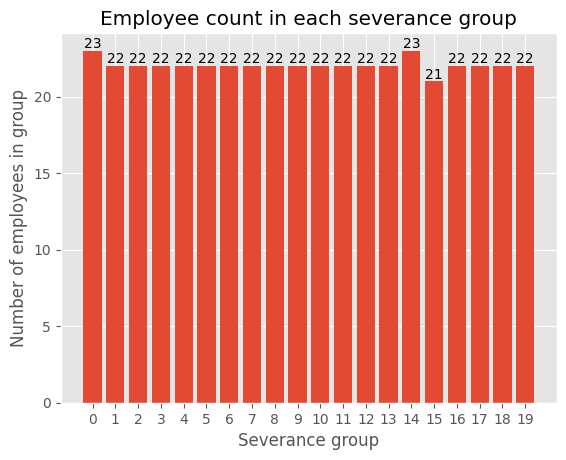

In [133]:
# Final grouping
# Make sure there's no NA
data['group_combined'] = data[category_cols].astype(str).agg('_'.join, axis=1)
assert not data.query(f'{category_name}_category_code < 0').shape[0]

data['severance_group'] = data['group_combined'].astype('category').cat.codes

severance_group_size = data.groupby('severance_group').size()

ax = plt.bar(severance_group_size.index, severance_group_size)
plt.xticks(severance_group_size.index)
plt.xlabel('Severance group')
plt.ylabel('Number of employees in group')
plt.title('Employee count in each severance group')
plt.bar_label(ax)

# Make sure there's enough employee in each category
min_employees = 5
assert (severance_group_size > min_employees).all()

In [134]:
# region Constraint 1: Min number to offer RCC: 40.
# This is based on the probability so no need to do anything here
# endregion

# region Constraint 2: Yearly saving from salary is > 3million
# we calculate the yearly rate from monthly rate. We can't use monthly income because
# that's what the employee receives, but we are actually interested in what the company
# has to pay out
data['YearlyRate'] = data['MonthlyRate'] * 12 * data['prob_take_rcc']
# endregion

# region Constraint 3: Leaving ppl are spread evenly across job roles.
data['JobRole'] = 'role_' + data['JobRole']
role_list = data['JobRole'].unique().tolist()
role_counts = data.groupby('JobRole').size()

# Transform to wide format
data = pd.concat(
    [
        data.drop(['JobRole'], axis=1),
        data[['JobRole', 'prob_take_rcc']].pivot(columns='JobRole', values='prob_take_rcc').fillna(0),
    ],
    axis=1,
)
# endregion

# region Constraint 4: >= 80% of the employees have to stay in each department
data['Department'] = 'dept_' + data['Department']
dept_list = data['Department'].unique().tolist()
dept_counts = data.groupby('Department').size()

# Transform to wide format
data = pd.concat(
    [
        data.drop(['Department'], axis=1),
        data[['Department', 'prob_take_rcc']].pivot(columns='Department', values='prob_take_rcc').fillna(0),
    ],
    axis=1,
)
# endregion

# endregion

# region Compute the statistics for each employee category
data['employee_count'] = 1
severance_group_stats = data.groupby('severance_group', as_index=False).agg({
    'prob_take_rcc': 'sum',  # constraint 1
    'YearlyRate': 'sum',  # constraint 2
    **{role: 'sum' for role in role_list},  # constraint 3
    **{dept: 'sum' for dept in dept_list},  # constraint 4
    'severance_package': 'sum',  # objective
    'employee_count': 'sum',  # total number of employees in each group
})

severance_group_stats.to_csv('./output/severance_groups.csv', index=False)
# endregion

In [135]:
# region Optimise
# region Setup
groups = severance_group_stats.copy()
model = LpProblem(name='test', sense=LpMinimize)

group_chosen = [LpVariable(name=f'severance_group{i}', cat='Binary') for i in groups['severance_group']]

severance_pays = groups['severance_package'].tolist()
total_employees_before = groups['employee_count'].sum()
# endregion

# region objective
objective = lpSum(
    [group * severance_package]
    for group, severance_package
    in zip(group_chosen, groups['severance_package'])
)

model += objective
# endregion

# region Constraint 1: Min number to offer RCC: 40.
employees_to_leave = lpSum([
    group * employee_count
    for group, employee_count
    in zip(group_chosen, groups['prob_take_rcc'])
])

employee_constraint = employees_to_leave >= 40

model += (employee_constraint, 'employee_to_offer_rcc')
# endregion

# region Constraint 2: Yearly saving from salary is >3 million
salary_constraint = lpSum([
    group * group_yearly_salary
    for group, group_yearly_salary
    in zip(group_chosen, groups['YearlyRate'])
]) >= 3_000_000

model += (salary_constraint, 'yearly_saving')
# endregion

# region Constraint 3: Leaving ppl are spread evenly across job roles.
tolerance = 0.1
roles = role_counts.index

total_employees_after = total_employees_before - employees_to_leave

for role in roles:
    # Number of employees in the current role before the RCC
    count_employee_in_role_before = role_counts[role]

    # Pct of employees from the current role before the RCC
    pct_in_role_before = count_employee_in_role_before / total_employees_before

    # Number of employees remaining in the current role after the RCC
    count_employee_in_role_after = count_employee_in_role_before - lpSum([
        group * count_employees_with_role_in_group
        for group, count_employees_with_role_in_group
        in zip(group_chosen, groups[role])
    ])

    # Target number of employees remaining in the current role after the RCC
    target_count_employee_in_role_after = pct_in_role_before * total_employees_after

    # Add constraint
    model += (
        count_employee_in_role_after >= (target_count_employee_in_role_after * (1 - tolerance)),
        f'min_remaining_{role}'
    )

    model += (
        count_employee_in_role_after <= (target_count_employee_in_role_after * (1 + tolerance)),
        f'max_remaining_{role}'
    )
# endregion

# region Constraint 4: >= 80% of the employees have to stay in each department
depts = dept_counts.index

for dept in depts:
    # Number of employees in the department before
    count_employee_in_department_before = dept_counts[dept]

    total_employee_in_dept_after = count_employee_in_department_before - lpSum([
        group * count_employees_in_department_in_group
        for group, count_employees_in_department_in_group
        in zip(group_chosen, groups[dept])
    ])

    model += (
        total_employee_in_dept_after >= (count_employee_in_department_before * 0.8),
        f'remaining_{dept}'
    )
# endregion

In [136]:
# show model
# print(model)

# Solve
status = model.solve()

# Get status
print('Solver status:', LpStatus[model.status])

Solver status: Optimal


In [137]:
# region gather optimisation results
severance_group_results = []
for var in model.variables():
    severance_group_results.append({
        'severance_group': int(var.name.replace('severance_group', '')),
        'rcc_offer': var.value()
    })
severance_group_results_df = pd.DataFrame(severance_group_results)

groups_results = pd.merge(
    groups,
    severance_group_results_df,
    on='severance_group'
)

rcc_offer_groups = groups_results.query('rcc_offer == 1')

data.merge(
    severance_group_results_df,
    on='severance_group'
).to_csv('./output/severance_offer/complete_case_severance_pay.csv', index=False)

# endregion

groups_results


,severance_group,prob_take_rcc,YearlyRate,role_Sales Executive,role_Manufacturing Director,role_Human Resources,role_Research Scientist,role_Laboratory Technician,role_Sales Representative,role_Healthcare Representative,role_Manager,role_Research Director,dept_Sales,dept_Research & Development,dept_Human Resources,severance_package,employee_count,rcc_offer
0,0,5.693013,1.041163e+06,0.000000,0.000000,0.387692,1.953802,2.800923,0.550596,0.000000,0.000000,0.000000,0.550596,4.754725,0.387692,9.775150e+04,23,1.0
1,1,4.421849,8.611082e+05,0.000000,0.000000,1.044601,0.350360,1.480842,1.546046,0.000000,0.000000,0.000000,1.546046,1.831202,1.044601,1.311660e+05,22,0.0
2,2,2.774556,5.835148e+05,1.639874,0.461354,0.006019,0.053015,0.127464,0.000000,0.486830,0.000000,0.000000,1.639874,1.128662,0.006019,4.341194e+05,22,0.0
3,3,1.550281,2.534086e+05,0.723693,0.394420,0.037349,0.105855,0.262918,0.000000,0.026045,0.000000,0.000000,0.723693,0.789239,0.037349,4.720118e+05,22,0.0
4,4,2.154064,4.530596e+05,1.192598,0.443603,0.000000,0.130941,0.010467,0.000000,0.376455,0.000000,0.000000,1.192598,0.961466,0.000000,5.167863e+05,22,1.0
5,5,1.820413,3.690333e+05,0.792993,0.185193,0.086273,0.001187,0.725525,0.000000,0.029242,0.000000,0.000000,0.792993,0.941147,0.086273,5.738644e+05,22,1.0
6,6,2.184737,4.187603e+05,1.809520,0.019630,0.038805,0.004426,0.057537,0.000000,0.254820,0.000000,0.000000,1.809520,0.336413,0.038805,6.618452e+05,22,0.0
7,7,2.100289,3.368965e+05,0.670323,0.908617,0.224158,0.000000,0.000000,0.000000,0.248400,0.048790,0.000000,0.670323,1.205808,0.224158,7.713128e+05,22,0.0
8,8,1.116007,1.385032e+05,0.684783,0.316448,0.000000,0.000000,0.000000,0.000000,0.005953,0.018487,0.090336,0.703269,0.412738,0.000000,8.991848e+05,22,0.0
9,9,1.916869,3.740539e+05,0.909059,0.120249,0.000000,0.000000,0.000000,0.000000,0.173986,0.591114,0.122462,0.945168,0.971701,0.000000,1.157769e+06,22,0.0


#### Results

In [138]:
# region analyse optimisation results
# Objective: severance pay
severance_pay = rcc_offer_groups['severance_package'].sum() / 1000000
print(f'Severance pay: €{severance_pay:.2f} million')

# Constraint 1: Number of people to offer RCC
leavings = rcc_offer_groups['prob_take_rcc'].sum()
print(f'Number of employees leaving: {leavings:.2f}')

assert leavings >= 40

# Constraint 2: Yearly saving
yearly_saving = rcc_offer_groups['YearlyRate'].sum() / 1000000
print(f'Yearly saving: €{yearly_saving:.2f} million')

assert yearly_saving > 3

# Constraint 3: Leaving ppl are spread evenly across job roles
total_headcount_after = total_employees_before - leavings

role_changes = pd.concat(
    [
        role_counts / total_employees_before * 100,  # before
        (role_counts - rcc_offer_groups[roles].sum()) / total_headcount_after * 100,  # after
    ],
    axis=1
)
role_changes.columns = ['pct_before', 'pct_after']
role_changes = role_changes.eval('relative_change = (pct_after - pct_before) / pct_before * 100').reset_index()
role_changes['JobRole'] = role_changes['JobRole'].str.replace('role_', '')

print('\n')
print('----------- Role changes')
print(role_changes)

assert (role_changes['relative_change'].abs() <= tolerance * 100).all()

# Constraint 4: >= 80% of the employees have to stay in each department
dept_changes = pd.concat(
    [
        dept_counts,  # before
        dept_counts - rcc_offer_groups[depts].sum(),  # after
    ],
    axis=1,
)
dept_changes.columns = ['employee_count_before', 'employee_count_after']
dept_changes = dept_changes.eval('pct_remaining = employee_count_after / employee_count_before * 100').reset_index()
dept_changes['Department'] = dept_changes['Department'].str.replace('dept_', '')

print('\n')
print('----------- Department changes')
print(dept_changes)

assert (dept_changes['pct_remaining'].abs() >= 0.8).all()

# endregion

# analyse protected attributes
data_protected = pd.merge(
    data,
    severance_group_results_df,
    on='severance_group'
)

# Gender
_ = analyse_rcc_offer_rate(data_protected, 'Gender')

# Age
data_protected['age_group'] = pd.qcut(data_protected['Age'], 5)
_ = analyse_rcc_offer_rate(data_protected, 'age_group')

# Marital Status
_ = analyse_rcc_offer_rate(data_protected, 'MaritalStatus')


Severance pay: €3.12 million
Number of employees leaving: 40.08
Yearly saving: €7.44 million


----------- Role changes
                     JobRole  pct_before  pct_after  relative_change
0  Healthcare Representative    9.523810  10.317927         8.338238
1            Human Resources    4.081633   4.066181        -0.378560
2      Laboratory Technician   18.140590  16.347855        -9.882448
3                    Manager    6.575964   7.233317         9.996310
4     Manufacturing Director   11.337868  11.913034         5.072962
5          Research Director    4.081633   4.489645         9.996310
6         Research Scientist   17.687075  17.020205        -3.770382
7            Sales Executive   24.716553  24.935851         0.887250
8       Sales Representative    3.854875   3.675984        -4.640660


----------- Department changes
               Department  employee_count_before  employee_count_after  pct_remaining
0         Human Resources                     21             19.302237 